# Bayesian inference

In [179]:
import sys, os
import logging
import numpy as np
from scipy.stats import uniform, norm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPatch
%matplotlib inline

sys.path.append('../')
import paper_settings
from simulation.units import *
from simulation.prior import get_grid
from inference.bayes import Posterior

In [180]:
paper_settings.setup()

## Setup

In [181]:
n = 100
n_events_for_expectation = 5000

In [182]:
filename = "calibrated_alices_full_sgd1e2_grid"

## Data

In [183]:
llr = np.load("../data/results/llr_{}.npy".format(filename))[:,:n_events_for_expectation]

In [184]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Calculate posterior on f_sub, beta

In [185]:
def narrow_prior(thetas):
    f_sub = thetas[:,0]
    beta = thetas[:,1]
    
    return uniform(0.001, 0.199).pdf(f_sub).flatten() * norm(-1.9, 0.1).pdf(beta).flatten()

In [186]:
bayes = Posterior(llr, theta_grid)
posterior_narrow = bayes.posterior_based_on_expected_llr(n, narrow_prior)

## Drawing from posterior

In [187]:
def draw_fsub_beta(posterior):
    posterior /= np.sum(posterior)
    
    # Draw bin
    i_bin = np.random.choice(list(range(625)), p=posterior)
    
    # Draw f_sub and theta uniformly within bin
    f_sub = theta_grid[i_bin][0] + (f_sub_1d[1] - f_sub_1d[0]) * (np.random.random() - 0.5)
    beta = theta_grid[i_bin][1] + (beta_edges[1] - beta_edges[0]) * (np.random.random() - 0.5)
    
    return f_sub, beta

## SHMF

In [188]:
def M_200_sigma_v(sigma_v, scatter=False):
    """
    Relate central velocity dispersion to halo virial mass
    From https://arxiv.org/pdf/1804.04492.pdf
    """
    a = 0.09
    b = 3.48
    if scatter:
        sigma_log10_M_200 = 0.13  # Lognormal scatter
        log10_M_200 = np.random.normal(a + b * np.log10(sigma_v / (100 * Kmps)), sigma_log10_M_200)
    else:
        log10_M_200 = a + b * np.log10(sigma_v / (100 * Kmps))
    return (10 ** log10_M_200) * 1e12 * M_s

In [189]:
def shmf_by_mhost(fsub, beta, msubs):
    """ Evaluates dn / dm for a given set of m (msubs)"""
    
    sigma_v = np.random.normal(225, 50)
    mhost = M_200_sigma_v(sigma_v * Kmps)
    
    m_min_calib=1e6 * M_s
    m_max_calib=0.01 * mhost
    M_0=M_MW
    m_0 = 1.e9 * M_s
                
    alpha = fsub * ((2 + beta) * M_0 * m_0 ** beta) / (m_max_calib ** (beta + 2) - m_min_calib ** (beta + 2))
    
    return np.where(msubs > m_max_calib, 0., alpha * (mhost / M_0) * (msubs / m_0)**beta / mhost)
                

## Find mean and credible intervals

In [190]:
def mean_and_ci(samples, levels=[0.68, 0.95]):
#     n_samples = samples.shape[0]
    mean = np.mean(samples, axis=0)
    all_down = [np.quantile(samples, (1. - level)/2, axis=0) for level in levels]
    all_up = [np.quantile(samples, 1. - (1. - level)/2, axis=0) for level in levels]
    all_cis = np.array([all_down, all_up])
    
#     # Loop over data points
#     all_cis = []
    
#     for samples_, mean_ in zip(samples.T, mean):
        
#         # Find position of mean in samples
#         sorted_ = sorted(samples_)
#         mean_pos = np.searchsorted(sorted_, mean_)
    
#         # Loop over levels and find lowest and highest position
#         cis = []
#         for level in levels:
#             half_n_ci = int(round(level * n_samples / 2,0))
#             low_pos, high_pos = mean_pos - half_n_ci, mean_pos + half_n_ci
#             if low_pos < 0:
#                 cis.append([sorted_[0], sorted_[2*half_n_ci]])
#             elif high_pos >= n_samples:
#                 cis.append([sorted_[-2*half_n_ci - 1], sorted_[-1]])
#             else:
#                 cis.append([sorted_[low_pos], sorted_[high_pos]])
                
#         all_cis.append(cis)
#     all_cis = np.array(all_cis)  # Shape (n_datapoints, n_cis, 2)
#     all_cis = all_cis.T  # Shape (2, n_cis, n_datapoints)

    return mean, all_cis

## Generate SHMF data

In [191]:
n_realizations = 20000
n_realizations_show = 0
fsub_true, beta_true = 0.05, -1.9
msubs = np.geomspace(1.e7, 1e12, 200) * M_s

In [192]:
shmf_posteriors = []
shmf_trues = []
for _ in range(n_realizations):
    fsub_, beta_ = draw_fsub_beta(posterior_narrow)
    shmf_posteriors.append(shmf_by_mhost(fsub_, beta_, msubs))
    shmf_trues.append(shmf_by_mhost(fsub_true, beta_true, msubs))
shmf_posteriors = np.asarray(shmf_posteriors)
shmf_trues = np.asarray(shmf_trues)

In [193]:
shmf_true, _ = mean_and_ci(shmf_trues, levels=[])
shmf_posterior, shmf_posterior_cis = mean_and_ci(shmf_posteriors, levels=[0.68, 0.95])

## Plot

In [194]:
x = 1./M_s * msubs
y_mult = msubs**2

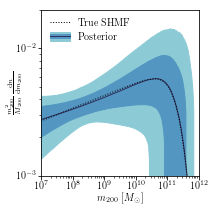

In [195]:
fig = paper_settings.figure()
ax = plt.gca()

for i, shmf_ in enumerate(shmf_posteriors[:n_realizations_show]):
    plt.plot(x, msubs**2 * shmf_,c="0.3", lw=0.25)
    
fillpost2 = plt.fill_between(x, y_mult * shmf_posterior_cis[0, 1], msubs**2 * shmf_posterior_cis[1, 1], facecolor=paper_settings.COLOR_FIX, edgecolor=paper_settings.COLOR_FIX)
fillpost1 = plt.fill_between(x, y_mult * shmf_posterior_cis[0, 0], msubs**2 * shmf_posterior_cis[1, 0], facecolor=paper_settings.COLOR_ALIGN, edgecolor=paper_settings.COLOR_ALIGN)
lpost, = plt.plot(x, y_mult * shmf_posterior, alpha=1., c=paper_settings.COLOR_FULL, lw=1.0, label="Posterior")
ltrue, = plt.plot(x, y_mult * shmf_true, alpha=1., c="black", lw=1.0, ls=":", label="True SHMF")

ax.add_patch(matplotlib.patches.Rectangle(xy=(1.93e7,1.147e-2), width=6.4e7, height=0.2e-2, facecolor=paper_settings.COLOR_FIX, edgecolor=paper_settings.COLOR_FIX))
ax.add_patch(matplotlib.patches.Rectangle(xy=(1.93e7,1.195e-2), width=6.4e7, height=0.09e-2, facecolor=paper_settings.COLOR_ALIGN, edgecolor=paper_settings.COLOR_ALIGN))

ax.legend(
    [ltrue, lpost],
    ["True SHMF", "Posterior"],
    loc=2,
    frameon=False
)

plt.xlabel(r"$m_{200}$ [$M_{\odot}$]")
ax.xaxis.set_label_coords(0.5, -0.11)
plt.ylabel(r"$\frac {m_{200}^2}{M_{200}} \frac{\mathrm{d}n}{\mathrm{d}m_{200}}$")
ax.yaxis.set_label_coords(-0.115, 0.5)
ax.yaxis.set_tick_params(pad=1)

plt.xscale("log")
plt.xlim(1.e7, 1.e12)
plt.yscale("log")
plt.ylim(0.001,0.02)
#plt.ylim(0., None)
    
plt.savefig("../figures/shmf.pdf", dpi=300)
